In [1]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu, gaussian
from skimage.filters import threshold_li
from skimage.filters import frangi
from skimage.color import rgb2gray
from skimage.morphology import closing, dilation, disk, skeletonize
from skimage.filters import threshold_local
from skimage.exposure import equalize_hist
from skimage.io import imread
import cv2

Found 67 .tif images.


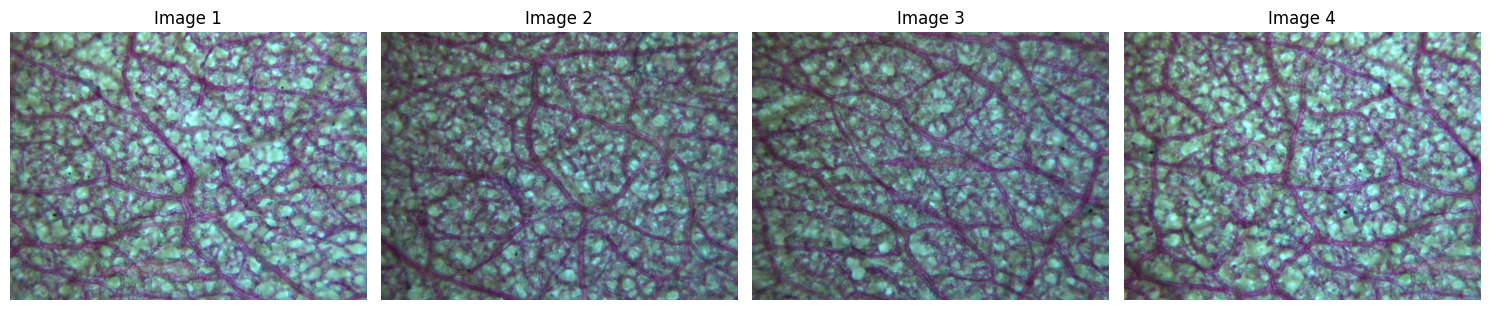

In [2]:
image_folder = "../datasets/ruthenium/original_images"

# Get all .tif files in the directory
image_paths = glob.glob(os.path.join(image_folder, "*.tif"))
print(f"Found {len(image_paths)} .tif images.")

# Load and display the first 5 images (or fewer if less than 5)
n_images_to_show = min(4, len(image_paths))

fig, axes = plt.subplots(1, n_images_to_show, figsize=(15, 5))
for i in range(n_images_to_show):
    img = imread(image_paths[i])
    ax = axes[i] if n_images_to_show > 1 else axes
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Image {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [3]:
image_path = image_paths[0]
image_rgb = imread(image_path)
image_gray = rgb2gray(image_rgb)

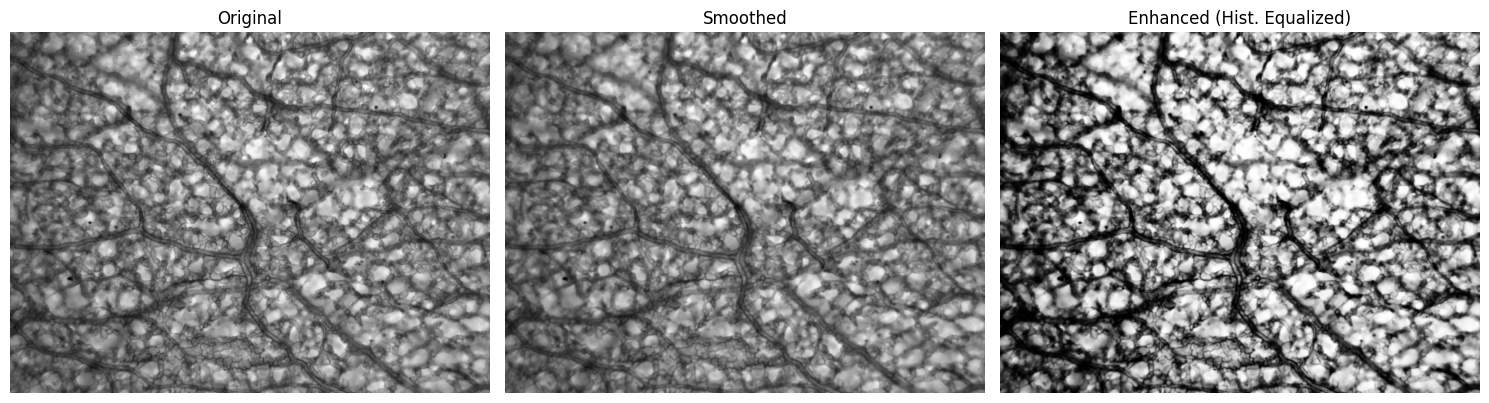

In [4]:
smooth = gaussian(image_gray, sigma=1)
enhanced = equalize_hist(smooth)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(smooth, cmap='gray')
axes[1].set_title("Smoothed")
axes[1].axis('off')

axes[2].imshow(enhanced, cmap='gray')
axes[2].set_title("Enhanced (Hist. Equalized)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

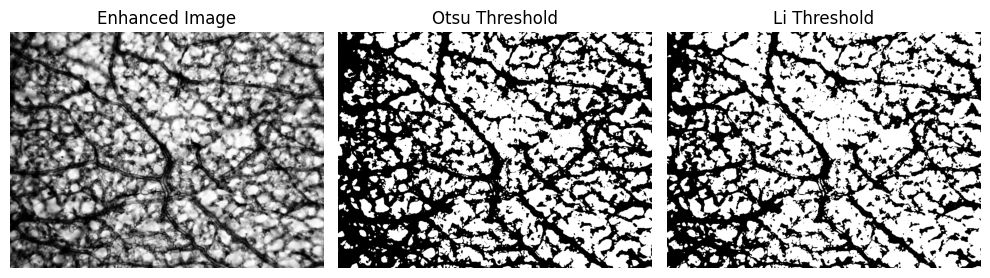

In [5]:
# Apply thresholds
thresh_otsu = threshold_otsu(enhanced)
binary_otsu = enhanced > thresh_otsu

thresh_li = threshold_li(enhanced)
binary_li = enhanced > thresh_li

# Show original and binary image
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(enhanced, cmap='gray')
axes[0].set_title("Enhanced Image")
axes[0].axis('off')

axes[1].imshow(binary_otsu, cmap='gray')
axes[1].set_title("Otsu Threshold")
axes[1].axis('off')

axes[2].imshow(binary_li, cmap='gray')
axes[2].set_title("Li Threshold")
axes[2].axis('off')

plt.tight_layout()
plt.show()

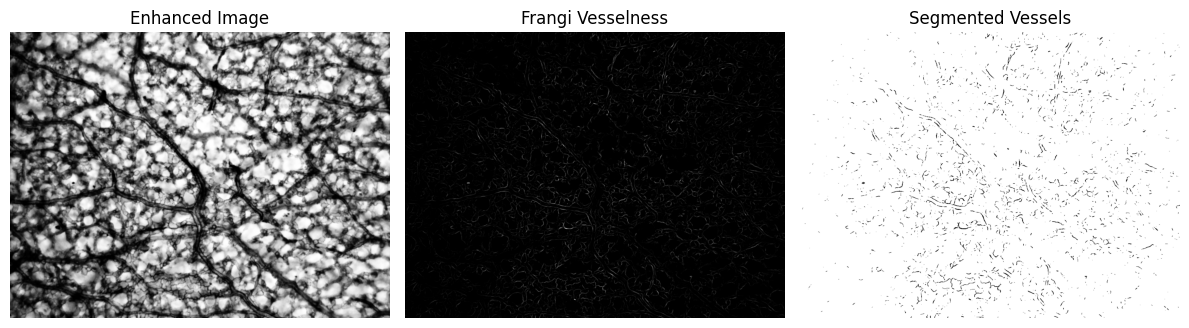

In [6]:
# Apply Frangi vesselness filter
vesselness = frangi(enhanced)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(enhanced, cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

#vesselness = np.logical_not(vesselness).astype(np.uint8)
plt.subplot(1, 3, 2)
plt.imshow(vesselness, cmap='gray')
plt.title('Frangi Vesselness')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(vesselness < 0.1, cmap='gray')  # Thresholded vesselness
plt.title('Segmented Vessels')
plt.axis('off')

plt.tight_layout()
plt.show()

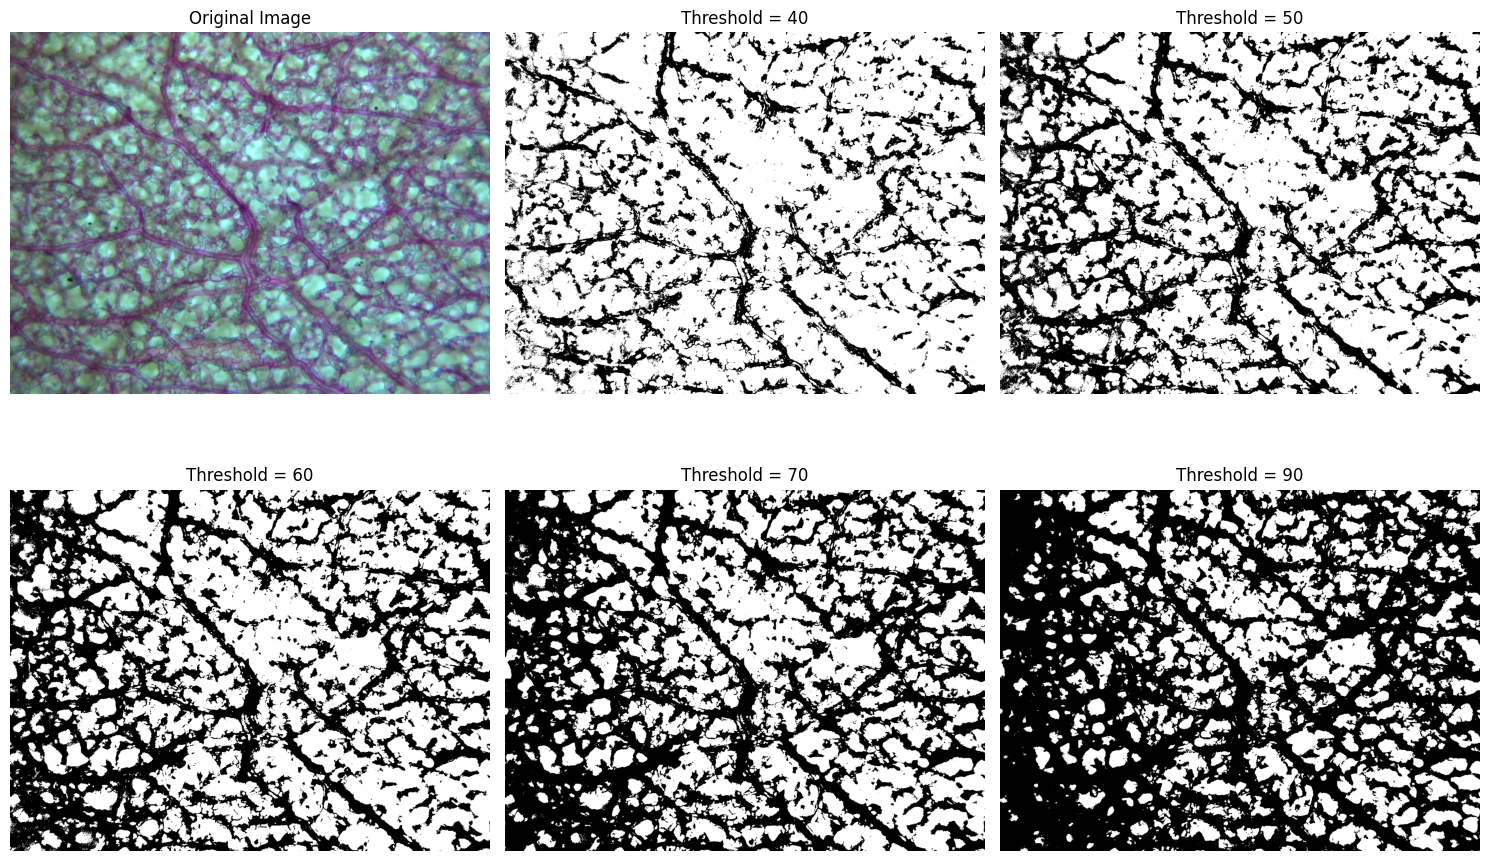

In [7]:
target_rgb = np.array([114, 68, 114])

# Compute distance from the target color
distance = np.linalg.norm(image_rgb - target_rgb, axis=2)

# Try different thresholds
thresholds = [40, 50, 60, 70, 90]
masks = [(distance < t) for t in thresholds]
inverted_masks = [np.logical_not(m).astype(np.uint8) for m in masks]

# Plot the original and segmented masks
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

for i, (t, mask) in enumerate(zip(thresholds, inverted_masks)):
    plt.subplot(2, 3, i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Threshold = {t}")
    plt.axis('off')

plt.tight_layout()
plt.show()


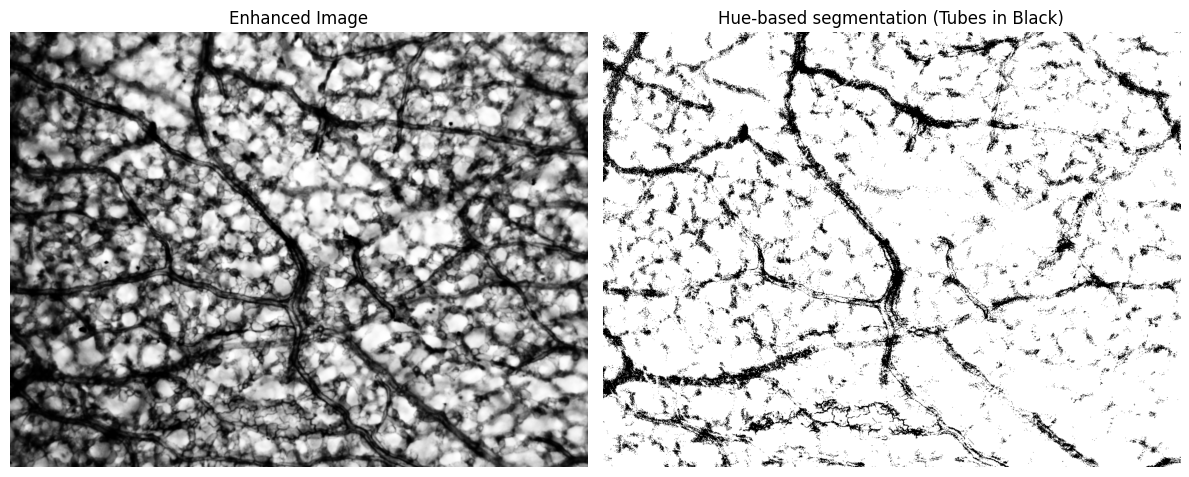

In [8]:
image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

hue = hsv[:, :, 0]  # Hue channel

# Red-purple hues are around 140-170 or 0-20 (OpenCV uses 0-179 scale)
mask1 = cv2.inRange(hue, 140, 170)
mask2 = cv2.inRange(hue, 0, 20)
tube_mask = cv2.bitwise_or(mask1, mask2)

# Invert: tubes as black
tube_mask_inv = cv2.bitwise_not(tube_mask)

# Display
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(enhanced, cmap='gray')
plt.title("Enhanced Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tube_mask_inv, cmap='gray')
plt.title("Hue-based segmentation (Tubes in Black)")
plt.axis('off')

plt.tight_layout()
plt.show()


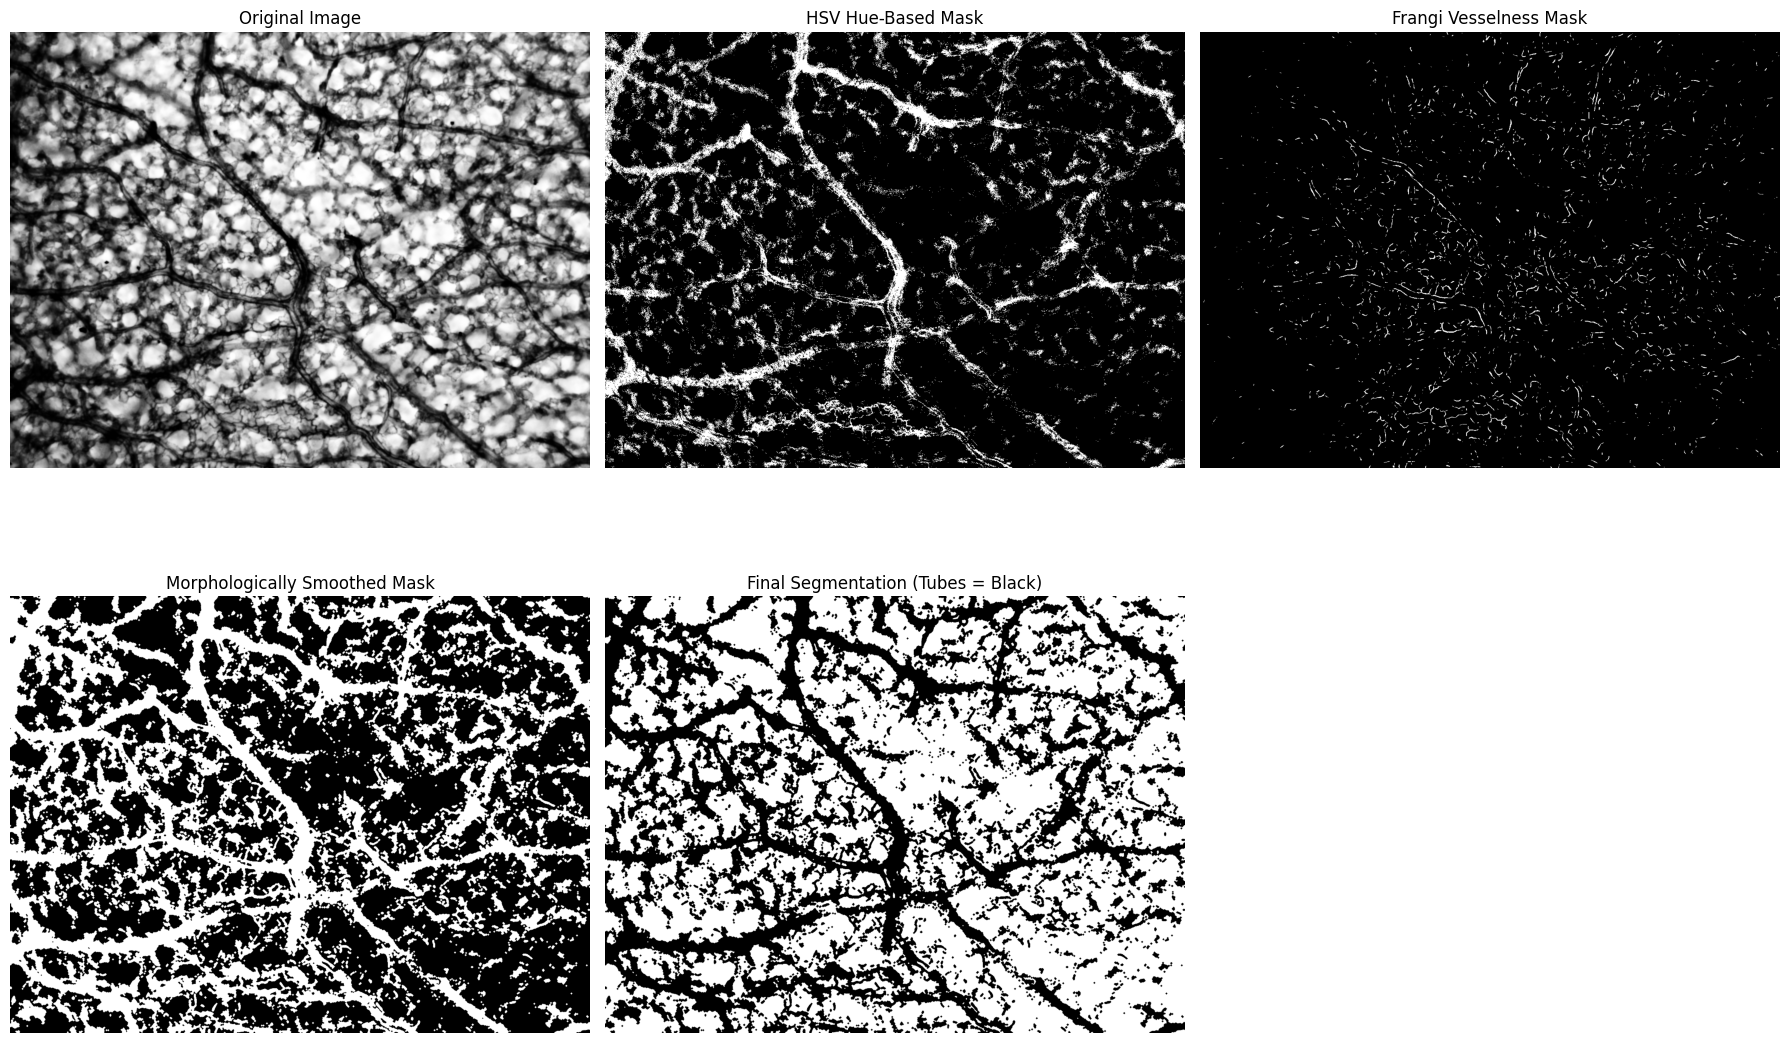

In [9]:
# Step 1: Color-based segmentation using HSV
image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
hue = hsv[:, :, 0]

# Mask red-purple hue ranges
mask1 = cv2.inRange(hue, 140, 170)
mask2 = cv2.inRange(hue, 0, 40)
color_mask = cv2.bitwise_or(mask1, mask2)
binary_color_mask = (color_mask > 0).astype(np.uint8)

# Step 2: Frangi vesselness filter
vessels = frangi(enhanced)
vessel_mask = (vessels > 0.1).astype(np.uint8)

# Step 3: Combine color and vesselness masks
combined_mask = np.logical_or(binary_color_mask, vessel_mask).astype(np.uint8)

# Step 4: Morphological processing
closed_mask = closing(combined_mask, disk(3))
dilated_mask = dilation(closed_mask, disk(2))
skeleton_mask = skeletonize(dilated_mask)

# Step 5: Adaptive thresholding
#adaptive_thresh = threshold_local(image_gray, block_size=51, offset=10)
#adaptive_mask = (image_gray < adaptive_thresh).astype(np.uint8)

# Final combination (color + vessel + adaptive)
final_mask = np.logical_or.reduce([
    dilated_mask,
#    adaptive_mask,
    skeleton_mask
]).astype(np.uint8)

# Invert for final display: tubes as black
inverted_final = np.logical_not(final_mask).astype(np.uint8)

# Plot all results
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.imshow(enhanced, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(binary_color_mask, cmap='gray')
plt.title("HSV Hue-Based Mask")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(vessel_mask, cmap='gray')
plt.title("Frangi Vesselness Mask")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(dilated_mask, cmap='gray')
plt.title("Morphologically Smoothed Mask")
plt.axis('off')

#plt.subplot(2, 3, 5)
#plt.imshow(adaptive_mask, cmap='gray')
#plt.title("Adaptive Thresholding")
#plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(inverted_final, cmap='gray')
plt.title("Final Segmentation (Tubes = Black)")
plt.axis('off')

plt.tight_layout()
plt.show()

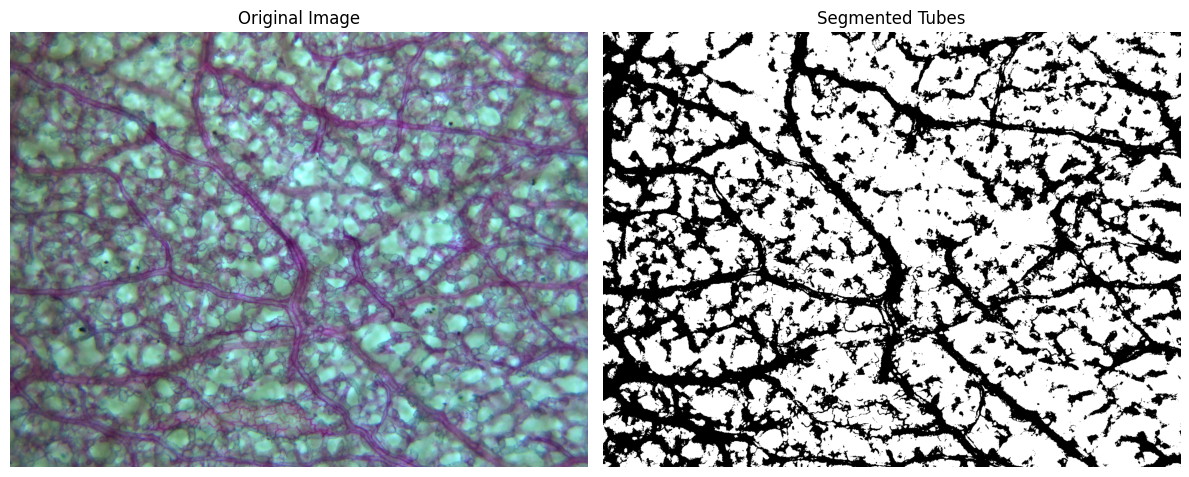

In [10]:
lab_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
h, w = lab_image.shape[:2]

# Normalize spatial coords to [0, 10]
x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))
x_coords = x_coords / w * 10
y_coords = y_coords / h * 10

coords = np.stack([y_coords, x_coords], axis=-1)

features = np.concatenate([lab_image, coords], axis=2).reshape(-1, 5)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(features)
segmented = labels.reshape(h, w)

target_rgb = np.uint8([[[114, 68, 114]]])
target_lab = cv2.cvtColor(target_rgb, cv2.COLOR_RGB2LAB)[0][0]

cluster_centers_lab = kmeans.cluster_centers_[:, :3]
distances = np.linalg.norm(cluster_centers_lab - target_lab, axis=1)
tube_cluster = np.argmin(distances)

tube_mask = (segmented == tube_cluster).astype(np.uint8)
inverted_mask = np.logical_not(tube_mask)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(inverted_mask, cmap='gray')
plt.title("Segmented Tubes")
plt.axis('off')

plt.tight_layout()
plt.show()